Load the three solved networks of the European sector coupled energy system representing the year 2030 with one key difference, the allowed CO2 limit is increased from 15% in network 1 to 30% of 1990 levels in network 2 to 40% of 1990 levels in network 3.

In [113]:
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the networks
networks = [pypsa.Network(r"Market Intergration Project/co2_1_elec_s_64_lv1.0__Co2L0.15-24H-T-H-B-I-A-solar+p3-dist1_2030.nc"), 
            pypsa.Network("Market Intergration Project/co2_2_elec_s_64_lv1.0__Co2L0.3-24H-T-H-B-I-A-solar+p3-dist1_2030.nc"), 
            pypsa.Network("Market Intergration Project/co2_3_elec_s_64_lv1.0__Co2L0.4-24H-T-H-B-I-A-solar+p3-dist1_2030.nc")]


INFO:pypsa.io:Imported network co2_1_elec_s_64_lv1.0__Co2L0.15-24H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network co2_2_elec_s_64_lv1.0__Co2L0.3-24H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network co2_3_elec_s_64_lv1.0__Co2L0.4-24H-T-H-B-I-A-solar+p3-dist1_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Installed Capacities

C:\Users\ykkba\AppData\Local\Temp\ipykernel_14108\3131885575.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



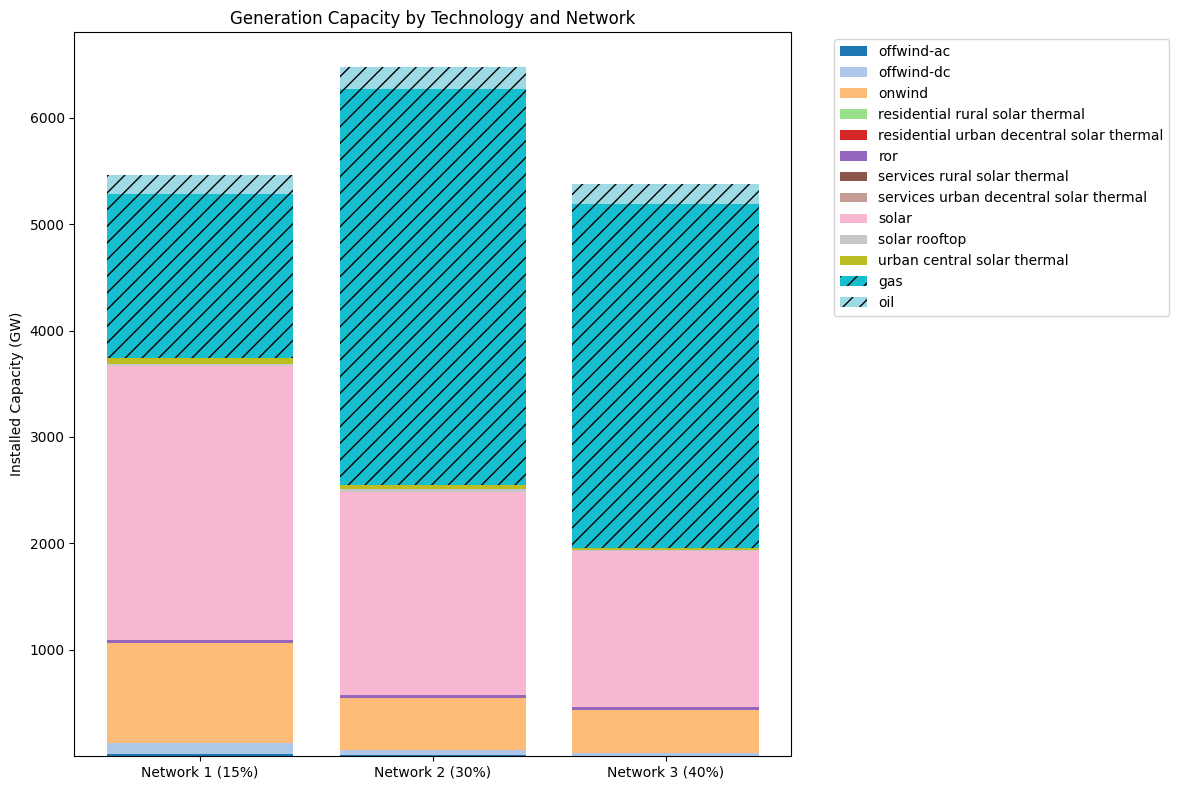

In [169]:
def plot_generation_capacity(networks):
    renewable_keywords = ['solar', 'wind', 'ror']
    
    # Get all unique technologies across all networks
    all_techs = set()
    for n in networks:
        all_techs.update(n.generators.carrier.unique())
    
    # Sort technologies: renewables first, then others
    techs = sorted(all_techs, key=lambda x: (not any(keyword in x.lower() for keyword in renewable_keywords), x))
    
    data = []
    for n in networks:
        tech_capacities = n.generators.groupby('carrier').p_nom_opt.sum()/1000 #GW
        data.append([tech_capacities.get(tech, 0) for tech in techs])

    data = np.array(data)

    # Create the stacked bar graph
    fig, ax = plt.subplots(figsize=(12, 8))
    bottom = np.zeros(3)

    colors = plt.cm.get_cmap('tab20')(np.linspace(0, 1, len(techs)))

    for i, tech in enumerate(techs):
        tech_capacity = data[:, i]
        is_renewable = any(keyword in tech.lower() for keyword in renewable_keywords)
        ax.bar(range(1, 4), tech_capacity, bottom=bottom, label=tech, 
               color=colors[i], hatch='' if is_renewable else '//')
        bottom += tech_capacity

    ax.set_xticks(range(1, 4))
    ax.set_xticklabels(['Network 1 (15%)', 'Network 2 (30%)', 'Network 3 (40%)'])
    ax.set_ylabel('Installed Capacity (GW)')
    ax.set_title('Generation Capacity by Technology and Network')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_generation_capacity(networks)

The average utilization in the electricity grid for each network


Text(0, 0.5, 'Average Grid Utilization (%)')

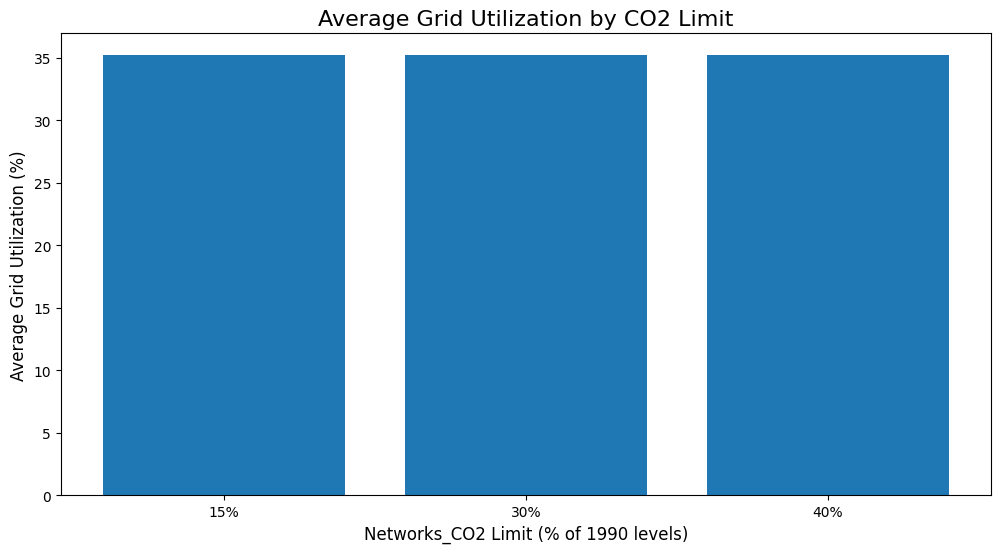

In [133]:
# Calculate average utilization for each network
for i, network in enumerate(networks, 1):
    # Get absolute power flow values
    power_flow = abs(network.lines_t.p0)
    
    # Get line capacities
    capacities = network.lines.s_nom

    # Calculate utilization
    utilization = power_flow.div(capacities, axis=1) *100

    # Calculate average utilization
    avg_utilization = utilization.mean().mean()


co2_limits = ['15%', '30%', '40%']

    # Create the bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(co2_limits, avg_utilization)

# Customize the plot
plt.title("Average Grid Utilization by CO2 Limit", fontsize=16)
plt.xlabel("Networks_CO2 Limit (% of 1990 levels)", fontsize=12)
plt.ylabel("Average Grid Utilization (%)", fontsize=12)


CO2 emissions by fuel across three networks

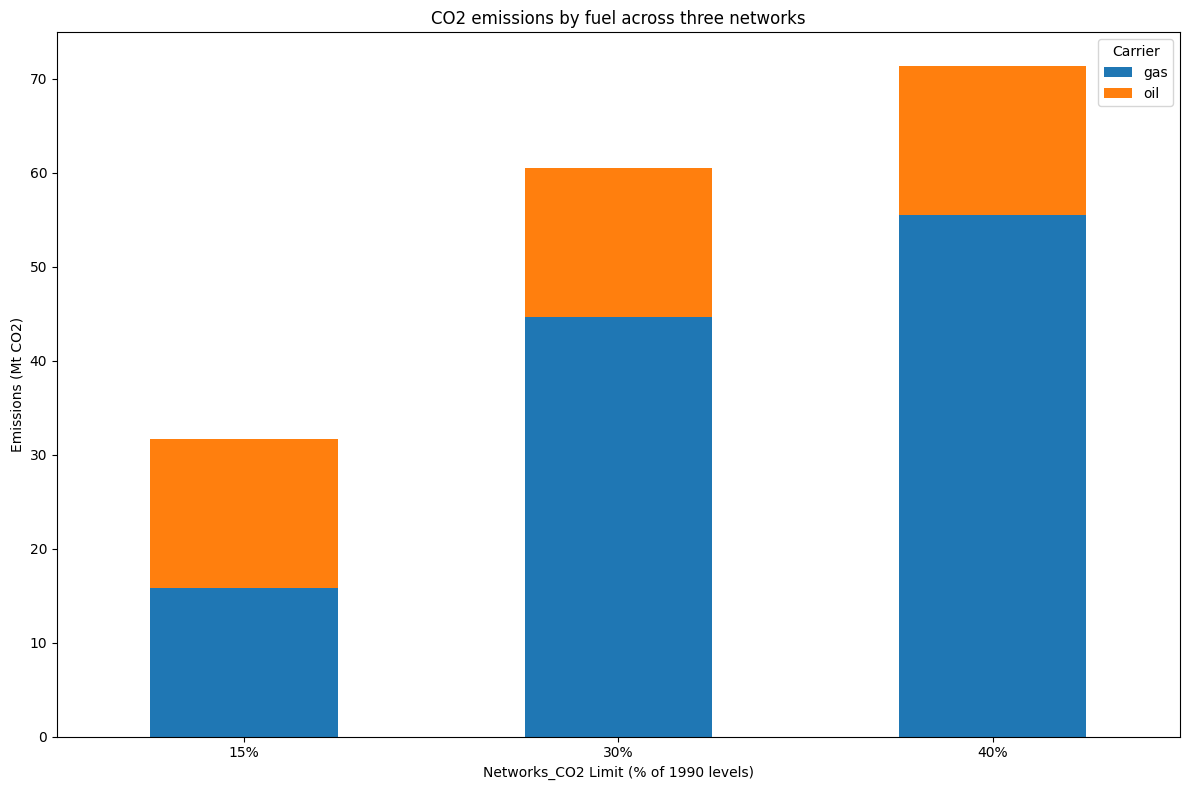

In [176]:
co2_limits = ['15%', '30%', '40%']

# Define emission factors for the generators (in tCO2/MWh)
emission_factors = {
    'gas': 0.2,
    'oil': 0.26641
}

# Function to calculate emissions by carrier
def get_emissions_by_carrier(n):
    if 'p' in n.generators_t:
        gen_dispatch = n.generators_t.p
    elif 'p_nom' in n.generators:
        gen_dispatch = n.generators.p_nom
    else:
        raise ValueError("Unable to find generator dispatch data")
    
    # Multiply dispatch by efficiency and emission factors
    emissions = (gen_dispatch.sum() * n.generators.efficiency).multiply(n.generators.carrier.map(emission_factors)) / 1000000 #tons_to_million_tons
    
    # Filter out carriers with zero emissions
    emissions = emissions[emissions > 0]
    
    # Sum emissions by carrier
    return emissions.groupby(n.generators.carrier).sum()

# Initialize data structure for plotting
emissions_data = pd.DataFrame()

# Calculate emissions for each network and compile data for plotting
for i, (n, co2_limit) in enumerate(zip(networks, co2_limits)):
    try:
        emissions = get_emissions_by_carrier(n)
        emissions_data[co2_limit] = emissions
    except Exception as e:
        print(f"Error processing network {i+1}: {str(e)}")

# Transpose the DataFrame for the desired plot layout
emissions_data = emissions_data.T

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

emissions_data.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('CO2 emissions by fuel across three networks')
ax.set_xlabel('Networks_CO2 Limit (% of 1990 levels)')
ax.set_ylabel('Emissions (Mt CO2)')
ax.set_xticklabels(co2_limits, rotation=0)
ax.legend(title='Carrier')

plt.tight_layout()
plt.savefig('emissions_by_carrier_stacked_networks.png', dpi=300, bbox_inches='tight')
plt.show()

The share of green to blue hydrogen supply

<Figure size 1200x600 with 0 Axes>

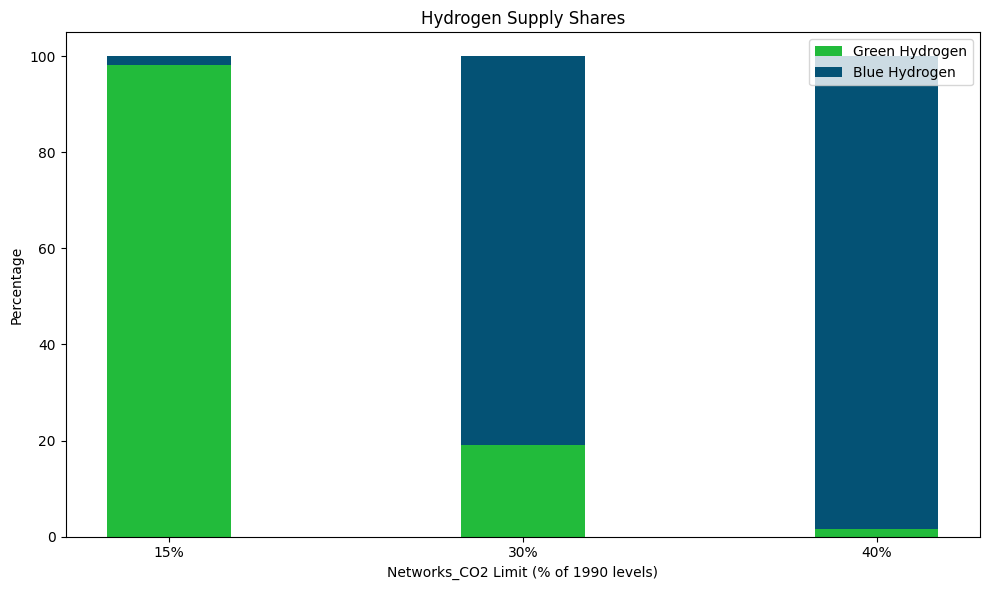

In [136]:
def hydrogen_supply_share(network):
    green_hydrogen_carriers = ['H2 Electrolysis']
    blue_hydrogen_carriers = ['SMR', 'SMR CC']

    green_hydrogen = network.links[network.links.carrier.isin(green_hydrogen_carriers)].p_nom_opt.sum()
    blue_hydrogen = network.links[network.links.carrier.isin(blue_hydrogen_carriers)].p_nom_opt.sum()
    total_hydrogen = green_hydrogen + blue_hydrogen

    if total_hydrogen > 0:
        green_share = green_hydrogen / total_hydrogen * 100
        blue_share = blue_hydrogen / total_hydrogen * 100
    else:
        green_share = blue_share = 0

    return green_share, blue_share

# Create the new bar graph for hydrogen shares
plt.figure(figsize=(12, 6))

green_shares = []
blue_shares = []

for n in networks:
    green, blue = hydrogen_supply_share(n)
    green_shares.append(green)
    blue_shares.append(blue)

x = ['15%', '30%', '40%']
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x, green_shares, width, label='Green Hydrogen', color='#22BB3B')
ax.bar(x, blue_shares, width, bottom=green_shares, label='Blue Hydrogen', color='#045275')

ax.set_ylabel('Percentage')
ax.set_xlabel('Networks_CO2 Limit (% of 1990 levels)')
ax.set_title('Hydrogen Supply Shares')
ax.legend()



plt.tight_layout()
plt.show()


The share of green electricity to the total electricity supplied in the network

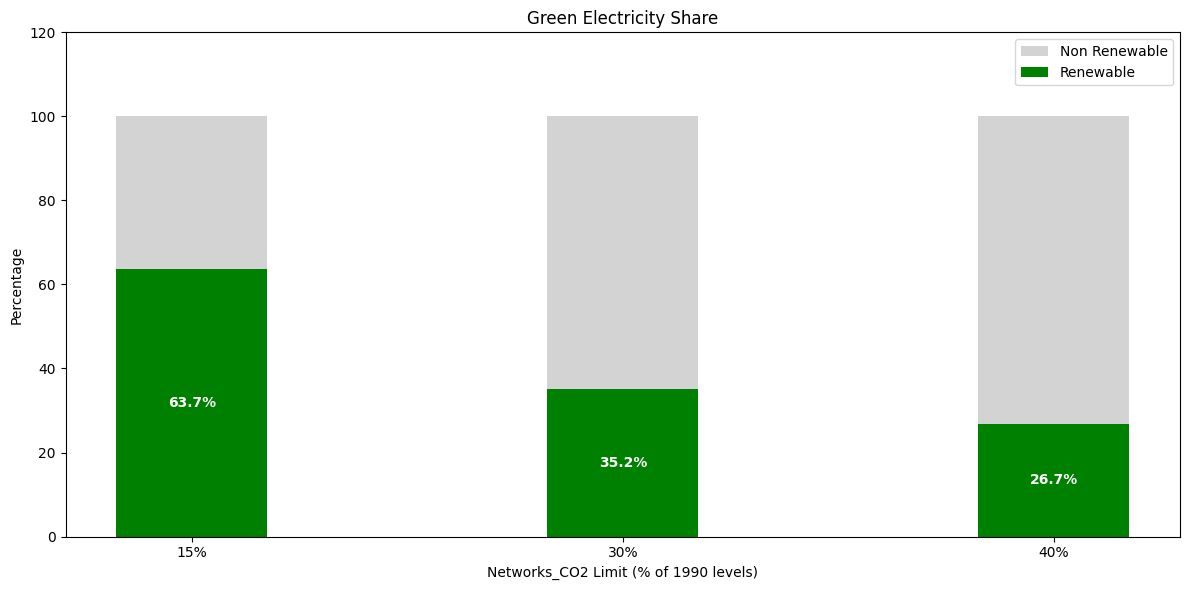

In [170]:
import matplotlib.pyplot as plt

def calculate_electricity_shares(network):
    total_gen = network.generators_t.p.sum().sum()
    
    renewable_keywords = ['solar', 'wind', 'ror']
    
    renewable_indices = [
        idx for idx, carrier in network.generators.carrier.items()
        if any(keyword in carrier.lower() for keyword in renewable_keywords)
    ]
    
    green_gen = network.generators_t.p[renewable_indices].sum().sum()
    
    green_share = green_gen / total_gen 
    fossil_share = 1 - green_share
    
    included_carriers = network.generators.loc[renewable_indices, 'carrier'].unique()
  
    
    return green_share, fossil_share

# Create the new bar graph for green electricity share
plt.figure(figsize=(12, 6))

green_shares = [calculate_electricity_shares(n)[0] for n in networks]
fossil_shares = [calculate_electricity_shares(n)[1] for n in networks]

x = ['15%', '30%', '40%']
width = 0.35

plt.bar(x, [100]*3, width, color='lightgray', label='Non Renewable')
green_bars = plt.bar(x, [g*100 for g in green_shares], width, color='green', label='Renewable')

plt.title('Green Electricity Share')
plt.xlabel('Networks_CO2 Limit (% of 1990 levels)')
plt.ylabel('Percentage')
plt.ylim(0, 120)

# Add percentage labels
for i, v in enumerate(green_shares):
    plt.text(i, v*50, f'{v:.1%}', ha='center', va='center', color='white', fontweight='bold')

# Add legend
plt.legend()

plt.tight_layout()
plt.show()

The installed capacity of direct air capture DAC

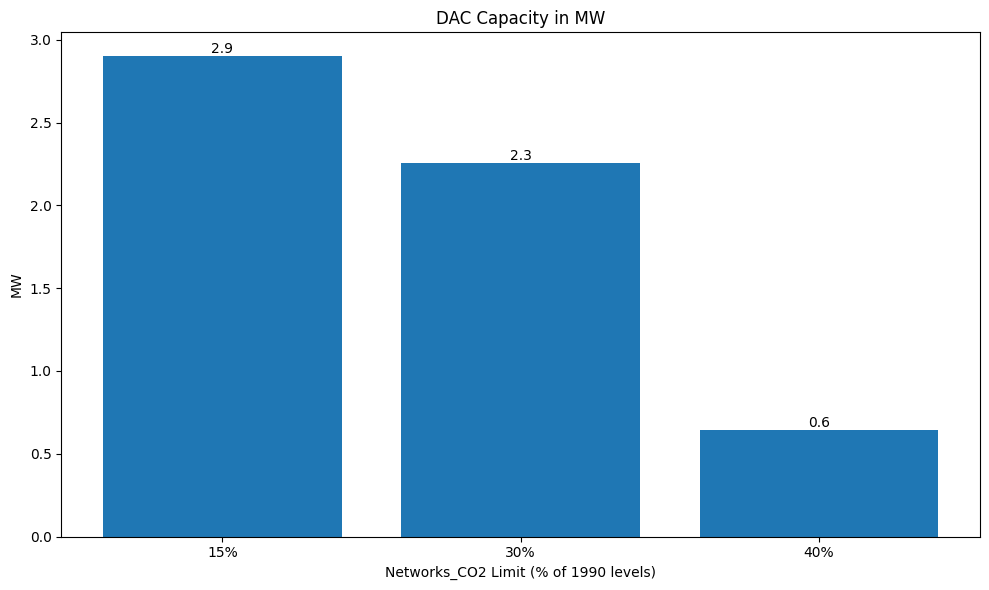

In [140]:
def analyze_dac_capacity(networks):
    dac_capacities = []
    for n in networks:
        dac_cap = n.links[n.links.carrier.str.lower() == "dac"].p_nom_opt.sum()
        dac_capacities.append(dac_cap)
    return dac_capacities

# Visualize key results
fig, ax = plt.subplots(figsize=(10, 6))

x = ['15%', '30%', '40%']
dac_capacities_gw = analyze_dac_capacity(networks)

# Convert DAC capacities from GW to MW
dac_capacities_mw = [capacity * 1000 for capacity in dac_capacities_gw]

ax.bar(x, dac_capacities_mw)
ax.set_title('DAC Capacity in MW')
ax.set_ylabel('MW')
ax.set_xlabel('Networks_CO2 Limit (% of 1990 levels)')

# Add value labels on top of each bar
for i, v in enumerate(dac_capacities_mw):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Investments in RES

Total RES investments (million EUR):
CO2 limit 15%: €264,130 million
CO2 limit 30%: €168,499 million
CO2 limit 40%: €131,398 million


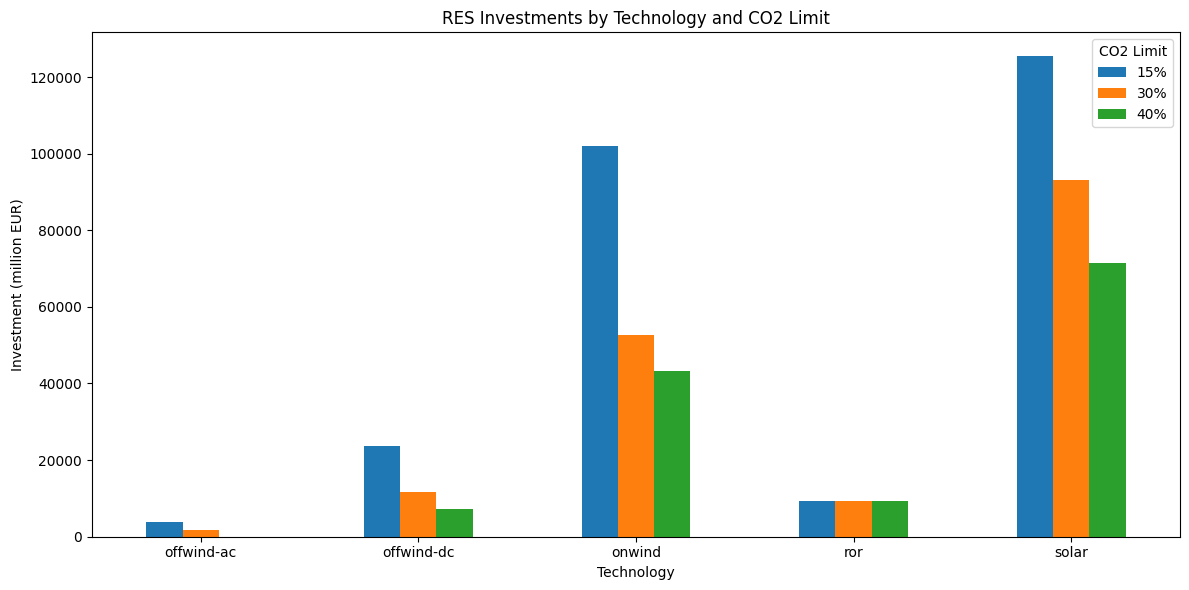


Detailed investment breakdown (million EUR):
                  15%       30%       40%
carrier                                  
offwind-ac    3748.84   1772.73      0.00
offwind-dc   23651.20  11694.21   7224.68
onwind      101987.91  52587.07  43385.33
ror           9348.52   9348.52   9348.52
solar       125393.31  93096.07  71438.98


In [173]:

co2_limits = ['15%', '30%', '40%']

def calculate_res_investment(network):
    res_technologies = ['onwind', 'offwind-ac', 'offwind-dc', 'solar', 'ror']

    
    res_generators = network.generators[network.generators.carrier.isin(res_technologies)]
    
    # Calculate investment costs and convert to million euros
    investment_costs = (res_generators.capital_cost * res_generators.p_nom_opt).groupby(res_generators.carrier).sum() / 1e6  
    
    return investment_costs

# Calculate investment for each network
investments = [calculate_res_investment(network) for network in networks]

# Create a DataFrame with all investments
df_investments = pd.concat(investments, axis=1, keys=co2_limits)
df_investments = df_investments.fillna(0)  # Replace NaN with 0 for technologies not present in all scenarios

# Print total investments
print("Total RES investments (million EUR):")
for limit in co2_limits:
    total = df_investments[limit].sum()
    print(f"CO2 limit {limit}: €{total:,.0f} million")


# Plot investments by technology for each scenario
ax = df_investments.plot(kind='bar', figsize=(12, 6))
plt.title('RES Investments by Technology and CO2 Limit')
plt.xlabel('Technology')
plt.ylabel('Investment (million EUR)')
plt.legend(title='CO2 Limit')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Print detailed breakdown
print("\nDetailed investment breakdown (million EUR):")
print(df_investments.round(2).to_string())

